# Project 4 - Estimated Demand System

## Table of Contents

1.
2.
3.

## Import Data Libraries

In [2]:
!pip install -r requirements.txt
!pip install pyarrow
!pip install eep153-tools

import pandas as pd
import numpy as np

from eep153_tools.sheets import read_sheets
import cfe

Missing dependencies for OracleDemands.


## Data Cleaning

We acquired our data from the Indian National Sample Survey (NSS). These original parque files contain data from a very large pool of households from 35 states; the following parts establish dataframes for our choosen Maharashtra population.

### Parquet Files

In [3]:
# read in parquet files 

# age-sex composition
pop = pd.read_parquet('z.parquet', engine = 'pyarrow')

#food quantity 
food_quant = pd.read_parquet('q.parquet', engine = 'pyarrow').unstack('i')

#total household expenditure in Rupee
expenditure = pd.read_parquet('total_expenditures.parquet', engine = 'pyarrow')

#food expenditure in Rupee
food_price = pd.read_parquet('x.parquet', engine = 'pyarrow').unstack('i')

### NSS Data (Raw)

We supplemented the parquet files with NSS data aquired from the Indian government.

In [4]:
dem_data = pd.read_stata('Household characteristics - Block 3 - Level2 - type2 - 68.dta')

## Helper functions

### `filter_pop`

The `filter_pop` function takes a raw dataframe and households characteristics as arguments and returns a `DataFrame` for the choosen population segement. The optional arguemnts help if you want to target specific demographic groups in the choosen state

**Input Parameters:**

- **df**: the name of the raw population df you want to extrapolate from
- **state**: an str (any state name from the 35 states)
- **rural**: optional; an str ('Rural' or 'Urban')
- **religion**: optional; an str ('Hinduism', 'Islam', 'Christianity', 'Sikhism', 'Buddhism', 'Others',             'Jainism', or 'Zoroastrianism')

In [3]:
def filter_pop(df, state, rural = None, religion = None):
    new = df.loc[df['m'] == state]
    if rural != None:
        new = new.loc[new['rural'] == rural]
    if religion != None:
        new= new.loc[new['religion'] == religion]
    return new

### `get_id`

The `get_id` function takes a raw dataframe and households characteristics as arguments, uses the `filter_pop` function, and  returns a list of household IDs for the chosen population

**Input Parameters:**

- **df**: the raw df you want to extrapolate from
- **state**: an str (any state name from the 35 states)
- **rural**: optional; an str ('Rural' or 'Urban')
- **religion**: optional; an str ('Hinduism', 'Islam', 'Christianity', 'Sikhism', 'Buddhism', 'Others',             'Jainism', or 'Zoroastrianism')

In [4]:
def get_id(df, state, rural = None, religion = None):
    ids = filter_pop(df = pop, state = state, rural = rural, religion = religion).index
    return ids

### `match_info`

The `match_info` function takes a raw dataframe and household_ids and returns a sliced df for the particular selected households

**Input Parameters:**

- **ids**: list of column ids
- **df**: the raw df you want to extrapolate from

In [5]:
def match_info(ids, df):
    n = df.reset_index()
    new = n[n['j'].isin(ids)]
    return new

### `dem_filter`

The `dem_filter` function takes the nss data, a list of attributes, and a district mapping, and returns a filtered, subsetted, and coded df for the given state. Codes used for household types, religion, and social class are from the NSS documentation.

In [8]:
columns = ['District','State_region','Sector','hh_size','HH_Type',
                        'Religion','Social_Group']

district_map = {'01':'Pashchim Champaran','02':'Purba Champaran','03':'Sheohar','04':'Sitamarhi','05':'Madhubani','06':'Supaul',
             '07':'Araria','08':'Kishanganj','09':'Purnia','10':'Katihar','11':'Madhepura','12':'Saharsa',
             '13':'Darbhanga','14':'Muzaffarpur','15':'Gopalganj','16':'Siwan','17':'Saran','18':'Vaishali',
             '19':'Samastipur','20':'Begusarai','21':'Khagaria','22':'Bhagalpur','23':'Banka','24':'Munger',
             '25':'Lakhisarai','26':'Sheikhpura','27':'Nalanda','28':'Patna','29':'Bhojpur','30':'Buxar','31':'Kaimur (Bhabua)',
             '32':'Rohtas','33':'Aurangabad','34':'Gaya','35':'Nawada','36':'Jamui','37':'Jehanabad','38':'Arwal'}

def dem_filter(state_id, columns, district_map, df):
    
    # filter for state and selected columns
    new = df.set_index('HHID')
    new = df[df['State_code'] == state_id]
    new = df[columns]
    
    # map districts
    new['District_map'] = new['District'].map(district_map)
    new = new.drop(['District'], axis=1)
    new.rename({'District_map': 'District'}, axis=1, inplace=True)
    
    # map household types 
    new['rural_urban'] = new['Sector'].map({'1':'rural','2':'urban'})
    newv= new.drop(['Sector'], axis=1)
    
    # map religion
    new['Religion_map'] = new['Religion'].map({'1':'Hinduism','2':'Islam',
                                                                   '3':'Christianity','4':'Sikhism',
                                                                   '5':'Jainism','6':'Buddhism',
                                                                   '7':'Zoroastrianism','9':'Others'})
    new = new.drop(['Religion'], axis=1)
    new.rename({'Religion_map': 'Religion'}, axis=1, inplace=True)
    
    return new

# df_bihar_demo.to_csv('hh_demograph_bihar.csv', index=True)

# Estimate Demand System <a name="demand"></a>

**Establish and format DataFrames for surveyed households**

In [6]:
bihar_id = get_id(df = pop, state = 'Bihar')
bihar_id

Index(['470441101', '470441102', '470441201', '470441202', '470441203',
       '470441204', '470441301', '470441302', '470471101', '470471102',
       ...
       '746982202', '746982301', '746991101', '746991201', '746991202',
       '746991301', '746992101', '746992201', '746992202', '746992301'],
      dtype='object', name='j', length=4582)

In [7]:
bihar_food_quant = match_info(bihar_id, food_quant) 

bihar_food_quant.drop('Frequency', inplace=True, axis=1) #drop unecessary column & level
bihar_food_quant.droplevel(0, axis=1)

# add the time 't' and market 'm' column
# since the data is from one year and one market (maharashtra), equate all to 1
bihar_food_quant['m'] = 1
bihar_food_quant['t'] = 1

bihar_food_quant.rename(columns = {'unit':'u'}, inplace = True) #rename & format
bihar_food_quant = bihar_food_quant.set_index(['j','t','m','u'])
bihar_food_quant.columns.name = 'i'

bihar_food_quant = bihar_food_quant.apply(lambda x: pd.to_numeric(x,errors='coerce'))
bihar_food_quant = bihar_food_quant.replace(0,np.nan)
bihar_food_quant = bihar_food_quant.droplevel(0, axis=1)
bihar_food_quant

/tmp/ipykernel_313/3209203294.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  bihar_food_quant.drop('Frequency', inplace=True, axis=1) #drop unecessary column & level


i                    apple  arhar (tur)  baby food  bajra & products  banana  \
j         t m u                                                                
470441101 1 1 Re       NaN          NaN        NaN               NaN     NaN   
              box      NaN          NaN        NaN               NaN     NaN   
              gm       NaN          NaN        NaN               NaN     NaN   
              kg       NaN       2500.0        NaN               NaN     NaN   
              litre    NaN          NaN        NaN               NaN     NaN   
...                    ...          ...        ...               ...     ...   
746992301 1 1 gm       NaN          NaN        NaN               NaN     NaN   
              kg       NaN       4000.0        NaN               NaN     NaN   
              litre    NaN          NaN        NaN               NaN     NaN   
              no       NaN          NaN        NaN               NaN     NaN   
              no.      NaN          NaN        NaN               NaN    12.0   

i                    barley & products  beef  beer  berries  besan  ...  \
j         t m u                                                     ...   
470441101 1 1 Re                   NaN   NaN   NaN      NaN    NaN  ...   
              box                  NaN   NaN   NaN      NaN    NaN  ...   
              gm                   NaN   NaN   NaN      NaN    NaN  ...   
              kg                   NaN   NaN   NaN      NaN    NaN  ...   
              litre                NaN   NaN   NaN      NaN    NaN  ...   
...                                ...   ...   ...      ...    ...  ...   
746992301 1 1 gm                   NaN   NaN   NaN      NaN    NaN  ...   
              kg                   NaN   NaN   NaN      NaN    NaN  ...   
              litre                NaN   NaN   NaN      NaN    NaN  ...   
              no                   NaN   NaN   NaN      NaN    NaN  ...   
              no.                  NaN   NaN   NaN      NaN    NaN  ...   

i                    toddy  tomato  turmeric  urd  vanaspati, margarine  \
j         t m u                                                           
470441101 1 1 Re       NaN     NaN       NaN  NaN                   NaN   
              box      NaN     NaN       NaN  NaN                   NaN   
              gm       NaN     NaN     150.0  NaN                   NaN   
              kg       NaN  2000.0       NaN  NaN                   NaN   
              litre    NaN     NaN       NaN  NaN                   NaN   
...                    ...     ...       ...  ...                   ...   
746992301 1 1 gm       NaN     NaN     450.0  NaN                   NaN   
              kg       NaN  2000.0       NaN  NaN                   NaN   
              litre    NaN     NaN       NaN  NaN                   NaN   
              no       NaN     NaN       NaN  NaN                   NaN   
              no.      NaN     NaN       NaN  NaN                   NaN   

i                    walnut  watermelon  wheat/atta - P.D.S.  \
j         t m u                                                
470441101 1 1 Re        NaN         NaN                  NaN   
              box       NaN         NaN                  NaN   
              gm        NaN         NaN                  NaN   
              kg        NaN         NaN                  NaN   
              litre     NaN         NaN                  NaN   
...                     ...         ...                  ...   
746992301 1 1 gm        NaN         NaN                  NaN   
              kg        NaN         NaN                  NaN   
              litre     NaN         NaN                  NaN   
              no        NaN         NaN                  NaN   
              no.       NaN         NaN                  NaN   

i                    wheat/atta - other sources  zarda,kimam,surti  
j         t m u                                                     
470441101 1 1 Re                    

In [8]:
bihar_tol_exp = match_info(bihar_id, expenditure)

In [9]:
bihar_food_exp = match_info(bihar_id, food_price)

bihar_food_exp.drop('Frequency', inplace=True, axis=1) #drop unecessary columns
bihar_food_exp.columns.name = 'i'
bihar_food_exp.set_index('j')
bihar_food_exp = bihar_food_exp.groupby('i',axis=1).sum()
bihar_food_exp = bihar_food_exp.replace(0,np.nan) # Replace zeros with NaN
bihar_food_exp.rename(columns={bihar_food_exp.columns[-1] :'j'}, inplace=True)

# add the time 't' and market 'm' column
#since the data is from one year (2016) and one market (maharashtra), equate all to 1
bihar_food_exp.insert(loc=165, column='t', value=1)
bihar_food_exp.insert(loc=166, column='m', value=1)

# Take logs of expenditures and name the new df 'y'
y = np.log(bihar_food_exp.set_index(['j','t','m']))

/tmp/ipykernel_313/3531070130.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  bihar_food_exp.drop('Frequency', inplace=True, axis=1) #drop unecessary columns


In [11]:
bihar_pop = match_info(bihar_id, pop) 
bihar_pop

# add the time 't' and market 'm' column
#since the data is from one year and one market, equate all to 1
bihar_pop['m'] = 1
bihar_pop['t'] = 1
bihar_pop.columns.name = 'k'
bihar_pop.set_index(['j','t','m'],inplace=True)
bihar_pop.drop(bihar_pop.columns[0:3], inplace=True, axis=1) #drop unecessary columns

# calculate and add new column 'log Hsize'
bihar_pop['log Hsize'] = np.log(bihar_pop.sum(axis=1).values)

## Estimation

### 1. First Step

In [12]:
result = cfe.Result(y=y,z=bihar_pop)

In [13]:
#the Result class has code to estimate the "reduced form" in one line:
result.get_reduced_form()

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprec

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprec

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserW

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

In [14]:
result.delta.to_dataframe().unstack('k')

delta                                   \
k                          Males 0-1 Males 1-5 Males 5-10 Males 10-15   
i                                                                       
apple                       0.015081  0.023740  -0.001758    0.029481   
arhar (tur)                -0.136516 -0.028130  -0.037376   -0.032567   
banana                      0.083756  0.033346  -0.020854    0.031227   
besan                       0.019746  0.048590   0.033520    0.072604   
biscuits, chocolates        0.207956  0.062673   0.063570    0.041874   
...                              ...       ...        ...         ...   
tomato                     -0.004120 -0.001469  -0.024495    0.023849   
turmeric                    0.031731 -0.010209  -0.005824   -0.014868   
vanaspati, margarine       -0.251547 -0.037182  -0.108519   -0.009712   
wheat/atta - P.D.S.        -0.041308 -0.030468  -0.043166   -0.033075   
wheat/atta - other sources -0.108356 -0.034351   0.012328    0.025543   

                                                                            \
k                          Males 15-20 Males 20-30 Males 30-50 Males 50-60   
i                                                                            
apple                         0.024213    0.133989    0.196242    0.286202   
arhar (tur)                  -0.010490    0.043225    0.074989    0.052914   
banana                        0.034277    0.066063    0.155318    0.168847   
besan                         0.092821    0.114826    0.096566    0.086292   
biscuits, chocolates          0.044919    0.044969    0.097150    0.094453   
...                                ...         ...         ...         ...   
tomato                        0.032182    0.037388    0.083313    0.095893   
turmeric                      0.032758    0.012791   -0.010626   -0.023170   
vanaspati, margarine         -0.008859    0.046374    0.148050    0.146116   
wheat/atta - P.D.S.          -0.044082   -0.005552    0.062667   -0.016139   
wheat/atta - other sources    0.058857    0.078877    0.109743    0.128269   

                                                                              \
k                          Males 60-100 Females 0-1 Females 1-5 Females 5-10   
i                                                                              
apple                          0.265295   -0.140623    0.053097     0.023434   
arhar (tur)                    0.033048   -0.161182   -0.082775    -0.019440   
banana                         0.219348    0.044778    0.012063     0.038675   
besan                          0.056425    0.100914    0.056529     0.086480   
biscuits, chocolates           0.093801    0.053425    0.021620     0.070353   
...                                 ...         ...         ...          ...   
tomato                         0.146637    0.091392   -0.012575    -0.012876   
turmeric                      -0.014817    0.014390   -0.006609    -0.004314   
vanaspati, margarine           0.147447   -0.023598    0.077440     0.047789   
wheat/atta - P.D.S.            0.020263   -0.044427   -0.019460    -0.040409   
wheat/atta - other sources     0.107525   -0.032546   -0.034265     0.029326   

                                                                      \
k                          Females 10-15 Females 15-20 Females 20-30   
i                                                                      
apple                           0.071070      0.030906      0.115768   
arhar (tur)                    -0.011916      0.033814      0.051284   
banana                          0.080946      0.027639      0.062529   
besan                           0.062067      0.070188      0.097812   
biscuits, chocolates            0.035099      0.052606      0.030803   
...                                  ...           ...           ...   
tomato                         -0.004413      0.040116      0.101543   
turmeric                        0.003210      0.047617      0.046079   
va

In [15]:
result.a.to_dataframe().unstack('i')

a                                                      \
i       apple arhar (tur)   banana     besan biscuits, chocolates   
t m                                                                 
1 1  4.122128    3.792514  2.72674  2.458455             2.989927   

                                                    \
i   black pepper bread (bakery)   brinjal  cabbage   
t m                                                  
1 1     2.078522       3.021142  2.797024  2.55153   

                                   ...                                       \
i   cake, pastry, prepared sweets  ... sewai, noodles sugar - other sources   
t m                                ...                                        
1 1                      3.685336  ...       2.615361              3.292829   

                                                                              \
i   suji, rawa tea : cups tea : leaf    tomato turmeric vanaspati, margarine   
t m                                                                            
1 1   1.997055   4.026201   2.792478  2.582637  2.33501             2.902733   

                                                    
i   wheat/atta - P.D.S. wheat/atta - other sources  
t m                                                 
1 1            3.833546                   4.292986  

[1 rows x 82 columns]

### 2. Second step:

The second step involves using Singular Value Decomposition to find
the rank one matrix that best approximates the residuals $e_{it}^j$.
This can be interpreted as
$$
    -\beta_i\log\lambda^j_t,
$$
where the $\log\lambda^j_t$ is the log of the marginal utility of
expenditures (MUE) for household $j$ at time $t$, and where $\beta_i$ are
the corresponding &ldquo;Frisch elasticities&rdquo; that tell us how much
demand changes as the MUE falls.

Estimates can also be computed as a one-liner:

In [16]:
result.get_beta(as_df=True)

i
apple                         0.505788
arhar (tur)                   0.215919
banana                        0.358731
besan                         0.344768
biscuits, chocolates          0.408524
                                ...   
tomato                        0.332323
turmeric                      0.203397
vanaspati, margarine          0.255417
wheat/atta - P.D.S.           0.036592
wheat/atta - other sources    0.128113
Name: beta, Length: 82, dtype: float64

### 3. Assessment of Fit

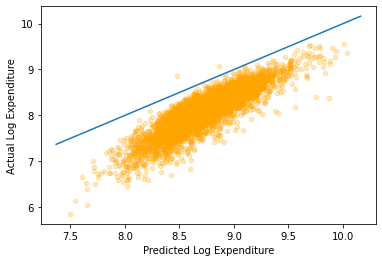

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()
xhat = result.get_predicted_expenditures().sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual Log Expenditure':np.log(xbar),'Predicted Log Expenditure':np.log(xhat)})

df.plot.scatter(x='Predicted Log Expenditure',y='Actual Log Expenditure', c = "orange", alpha = 0.25)

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax])

In [23]:
#save estimate result in datahub
result.to_dataset('bihar.ds')

<xarray.Dataset>
Dimensions:           (j: 4582, i: 82, k: 19, t: 1, m: 1, kp: 19)
Coordinates:
  * j                 (j) object '470441101' '470441102' ... '746992301'
  * t                 (t) int64 1
  * m                 (m) int64 1
  * i                 (i) object 'apple' ... 'wheat/atta - other sources'
  * k                 (k) <U14 'Males 0-1' 'Males 1-5' ... 'log Hsize'
  * kp                (kp) <U14 'Males 0-1' 'Males 1-5' ... 'log Hsize'
Data variables: (12/20)
    alpha             (i) float64 4.122 3.793 2.727 2.458 ... 2.903 3.834 4.293
    beta              (i) float64 0.5058 0.2159 0.3587 ... 0.2554 0.03659 0.1281
    delta             (k, i) float64 0.01508 -0.1365 0.08376 ... 0.1263 0.6546
    prices            object None
    characteristics   (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... 1.946 1.792 1.792
    loglambdas        (j, t, m) float64 -2.198 -0.5867 ... -0.1658 -0.4631
    ...                ...
    se_beta           object None
    se_alpha          (i) float64 0.02185 0.01377 0.01363 ... 0.009588 0.007431
    se_a              (i, t, m) float64 0.02185 0.01377 ... 0.009588 0.007431
    y                 (i, j, t, m) float64 nan nan nan nan ... 6.62 6.109 6.397
    logp              object None
    z                 (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... 1.946 1.792 1.792

In [24]:
result.get_alpha()

<xarray.DataArray 'alpha' (i: 82)>
array([4.12212813, 3.7925139 , 2.72674023, 2.45845497, 2.98992665,
       2.07852226, 3.02114243, 2.79702371, 2.55152957, 3.68533579,
       2.35380246, 3.04626708, 4.13355399, 1.83036338, 2.86310683,
       4.86856311, 3.57521899, 2.28716733, 1.81466106, 1.91559294,
       4.0876099 , 3.34441046, 4.56155942, 4.82485131, 4.05163917,
       2.61229115, 1.67512024, 1.39853807, 4.79599357, 2.74413584,
       3.40062152, 2.8840807 , 2.67774144, 2.45568222, 2.12480253,
       1.97446265, 3.93614106, 3.68811962, 2.93173191, 3.1205776 ,
       1.77264409, 5.36990863, 2.44820715, 2.50749692, 3.41556835,
       1.26948059, 5.31732875, 3.5061675 , 2.68642008, 4.30721161,
       1.34652378, 2.89569395, 3.33512416, 3.17550269, 4.74020939,
       2.95217265, 3.4459344 , 2.29826471, 3.33887562, 3.03865841,
       2.44632906, 4.10112389, 2.97771058, 3.10250129, 2.61553268,
       3.59051107, 2.01746354, 3.30325708, 3.22220213, 4.28353001,
       4.71906763, 1.58581898, 2.61536117, 3.29282901, 1.99705512,
       4.02620073, 2.79247833, 2.58263673, 2.33500974, 2.90273293,
       3.833546  , 4.29298631])
Coordinates:
  * i        (i) object 'apple' 'arhar (tur)' ... 'wheat/atta - other sources'

In [25]:
result

<xarray.Result>
Dimensions:           (j: 4582, i: 82, k: 19, t: 1, m: 1, kp: 19)
Coordinates:
  * j                 (j) object '470441101' '470441102' ... '746992301'
  * t                 (t) int64 1
  * m                 (m) int64 1
  * i                 (i) object 'apple' ... 'wheat/atta - other sources'
  * k                 (k) <U14 'Males 0-1' 'Males 1-5' ... 'log Hsize'
  * kp                (kp) <U14 'Males 0-1' 'Males 1-5' ... 'log Hsize'
Data variables: (12/20)
    alpha             (i) float64 4.122 3.793 2.727 2.458 ... 2.903 3.834 4.293
    beta              (i) float64 0.5058 0.2159 0.3587 ... 0.2554 0.03659 0.1281
    delta             (k, i) float64 0.01508 -0.1365 0.08376 ... 0.1263 0.6546
    prices            object None
    characteristics   (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... 1.946 1.792 1.792
    loglambdas        (j, t, m) float64 -2.198 -0.5867 ... -0.1658 -0.4631
    ...                ...
    se_beta           object None
    se_alpha          (i) float64 0.02185 0.01377 0.01363 ... 0.009588 0.007431
    se_a              (i, t, m) float64 0.02185 0.01377 ... 0.009588 0.007431
    y                 (i, j, t, m) float64 nan nan nan nan ... 6.62 6.109 6.397
    logp              object None
    z                 (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... 1.946 1.792 1.792
Attributes:
    firstround:            1
    min_proportion_items:  0.125
    min_xproducts:         30
    all_tm:                True
    common_alpha:          True
    useless_expenditures:  False
    stderr_tol:            0.01
    indices:               Indices(j='j', t='t', m='m', i='i', k='k')
    iterate:               False
    verbose:               False

### 4. Infer Prices

In [34]:
# Estimates most things (not counting std errors for betas).
xhat = result.get_predicted_expenditures(as_df = True) 
result.get_beta(as_df=True).sort_values(ascending=False).tail(30) # Check sanity & income elasticities 

i
eggs                          0.206563
turmeric                      0.203397
dhania                        0.200991
gram (whole)                  0.199033
moong                         0.198580
gourd, pumpkin                0.186336
other fuel                    0.186064
cabbage                       0.178180
candle                        0.178150
potato                        0.171119
cauliflower                   0.164122
dung cake                     0.161172
kerosene-other sources        0.157619
maida                         0.156576
oilseeds                      0.148084
electricity                   0.147126
rice - other sources          0.144601
gram (split)                  0.138759
cooked meals                  0.138584
wheat/atta - other sources    0.128113
leaf tobacco                  0.122479
masur                         0.108013
salt                          0.107528
lpg                           0.084101
firewood & chips              0.051047
wheat/atta - P.D.S.    

In [35]:
phat = xhat/bihar_food_quant
# Keep kgs; g
phat = phat.xs('kg',level='u').groupby(['t','m']).median().T.dropna(how='all')
result['prices'] = phat.stack().to_xarray().to_array()
# Make this persistent...
result.to_dataset('./foo.ds')

<xarray.Dataset>
Dimensions:           (i: 82, j: 4582, k: 19, variable: 1, m: 1, t: 1, kp: 19)
Coordinates:
  * i                 (i) object 'apple' ... 'wheat/atta - other sources'
  * j                 (j) object '470441101' '470441102' ... '746992301'
  * t                 (t) int64 1
  * m                 (m) int64 1
  * k                 (k) <U14 'Males 0-1' 'Males 1-5' ... 'log Hsize'
  * kp                (kp) <U14 'Males 0-1' 'Males 1-5' ... 'log Hsize'
  * variable          (variable) int64 1
Data variables: (12/20)
    alpha             (i) float64 4.122 3.793 2.727 2.458 ... 2.903 3.834 4.293
    beta              (i) float64 0.5058 0.2159 0.3587 ... 0.2554 0.03659 0.1281
    delta             (k, i) float64 0.01508 -0.1365 0.08376 ... 0.1263 0.6546
    prices            (variable, i, m) float64 0.07504 0.07551 ... 0.01283
    characteristics   (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... 1.946 1.792 1.792
    loglambdas        (j, t, m) float64 -2.198 -0.5867 ... -0.1658 -0.4631
    ...                ...
    se_beta           object None
    se_alpha          (i) float64 0.02185 0.01377 0.01363 ... 0.009588 0.007431
    se_a              (i, t, m) float64 0.02185 0.01377 ... 0.009588 0.007431
    y                 (i, j, t, m) float64 nan nan nan nan ... 6.62 6.109 6.397
    logp              object None
    z                 (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... 1.946 1.792 1.792

### 5. Predicting Positive Consumption
An issue with our assessment of fit is that we *predicted* that every household would consume positive quantitites of every good, and in making our assessment we ignored the (many) cases in which in fact the household had zero expenditures on that good.  

Here we&rsquo;re going to go back and use similar framework to try and estimate the probability with which we&rsquo;ll observe zero expenditures as a function of &lambda;, prices, and household characteristics.

In [36]:
zeros_r = cfe.Result(y=(0.+(np.exp(result.y)>0)),z=result.z)
weights = zeros_r.get_predicted_log_expenditures()

# Truncate to make weights live in [0,1]
weights = weights.where((weights<1) + np.isnan(weights),1).where((weights>0) + np.isnan(weights),0)

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()

# Calculate *expected* predicted expenditures, to make unconditional on being positive
xhat = (weights*result.get_predicted_expenditures())
xsum = xhat.sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserW

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserW

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprec

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserW

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (1, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprec

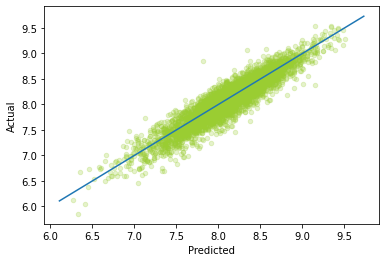

In [37]:
# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xsum)})

df.plot.scatter(x='Predicted',y='Actual', c = "yellowgreen", alpha = 0.25)

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax])

### 6. Predicting Quantities
Now divide predicted expenditures by predicted prices to get predicted quantities, and put back into a dataframe.

In [38]:
xx = result.get_predicted_expenditures() 
xhatdf = xx.to_dataset('i').to_dataframe()
xhatdf.columns.name ='i'

qhat = xhatdf.div(phat.T,axis=1)

qhat

i                    apple  arhar (tur)  banana       besan  \
t m j                                                         
1 1 470441101  2639.995325  1659.125400     NaN  726.465664   
    470441102  1042.342338  1136.653880     NaN  448.704296   
    470441201  1047.269911  1482.081243     NaN  636.119070   
    470441202  1368.947645  1495.042945     NaN  627.090476   
    470441203  1178.226715  1569.226732     NaN  536.378372   
...                    ...          ...     ...         ...   
    746991301   818.075816  1185.856009     NaN  390.549518   
    746992101  1761.883867  1581.923169     NaN  673.508449   
    746992201  1224.662724  1629.563371     NaN  775.193248   
    746992202   849.968397  1229.531228     NaN  451.985302   
    746992301   999.437128  1403.794014     NaN  555.605846   

i              biscuits, chocolates  black pepper  bread (bakery)  \
t m j                                                               
1 1 470441101                   NaN           NaN      640.673689   
    470441102                   NaN           NaN      520.619697   
    470441201                   NaN           NaN      722.342601   
    470441202                   NaN           NaN      670.925393   
    470441203                   NaN           NaN      566.039238   
...                             ...           ...             ...   
    746991301                   NaN           NaN      419.703903   
    746992101                   NaN           NaN      888.868063   
    746992201                   NaN           NaN      816.053673   
    746992202                   NaN           NaN      749.330235   
    746992301                   NaN           NaN      562.458754   

i                  brinjal      cabbage  cake, pastry, prepared sweets  ...  \
t m j                                                                   ...   
1 1 470441101  2804.504727  3002.372978                            NaN  ...   
    470441102  1903.614296  2050.762277                            NaN  ...   
    470441201  2724.921981  3024.971187                            NaN  ...   
    470441202  2597.196392  2752.571949                            NaN  ...   
    470441203  2397.189358  2426.329423                            NaN  ...   
...                    ...          ...                            ...  ...   
    746991301  1885.976948  1998.876552                            NaN  ...   
    746992101  3056.985244  3448.068862                            NaN  ...   
    746992201  3388.330856  3676.724472                            NaN  ...   
    746992202  2390.560497  2676.606615                            NaN  ...   
    746992301  2462.354060  2697.384497                            NaN  ...   

i              sewai, noodles  sugar - other sources  suji, rawa  tea : cups  \
t m j                                                                          
1 1 470441101      646.271095            3484.198321  913.260804         NaN   
    470441102      451.076979            1976.960460  591.110329         NaN   
    470441201      501.180769            3182.126511  812.989933         NaN   
    470441202      580.936474            3083.668613  799.348157         NaN   
    470441203      508.116536            3047.975725  716.216142         NaN   
...                       ...                    ...         ...         ...   
    746991301      360.327070            2218.918560  573.532131         NaN   
    746992101      570.730350            3757.830670  918.773581         NaN   
    746992201      390.618667            3923.919248  760.484785         NaN   
    746992202      415.734213            2447.303856  709.051125         NaN   
    746992301      413.266254            2962.946298  676.660104         NaN   

i              tea : leaf       tomato  turmeric  vanaspati, margarine  \
t m j                                                                    
1 1 470441101         NaN  2807.114109       NaN            695.1

In [39]:
qhat.to_csv('qhat.csv')

## Mapping

In [ ]:
import geopandas as gpd
from pathlib import Path
from matplotlib.ticker import FuncFormatter